# <center>ASTR4004/8004 - Inference - Part 3</center> 

## Bayes' theorem:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)}
$$

* $P(D|\theta)$: the likelihood function, representing the probability of observing the data ($D$) given a specific set of modeling parameters ($\theta$)
* $P(\theta)$: the prior probability distribution over the modeling parameters ($\theta$). This represents our initial beliefs of possible values of $\theta$
* $P(D)\equiv \sum \limits_{\theta} P(D,\theta)=\sum \limits_{\theta} P(D|\theta)P(\theta) = \int {\rm d}\theta P(\theta) P(D|\theta)$: the marginal likelihood or Bayesian evidence, representing the overall probability of observing the data (D)
* $P(\theta|D)$: the posterior probability distribution over the modeling parameters ($\theta$) given the data.

This notebook fits the correlation between input and output using the `emcee` package. We will also make `corner` plot to show the posterior.

## Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

## Data (D) and the task
We will be given a dataset `(x, y)` and the task is to fit a linear function of `y=mx+b` to these data points.

Text(0, 0.5, 'y')

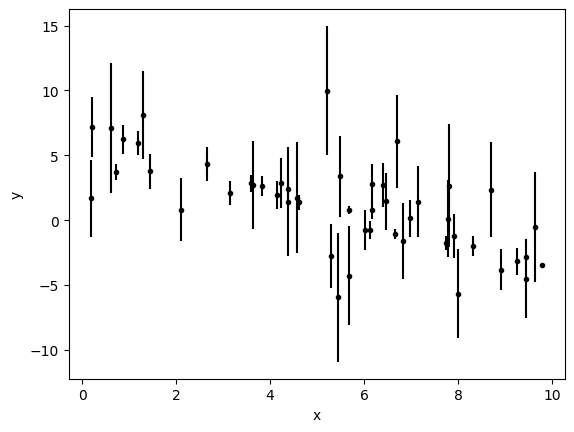

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Generate dataset (100 data points) following y = m * x +b
m_true = -0.9
b_true = 5.3

n_data = 50
x = np.sort(10 * np.random.random(n_data)) # uniform random points between 0 and 10
yerr = 0.1 + 5.0 * np.random.random(n_data) # generate a uniform random error (standard deviation) between 0.1 and 5.1
y = m_true * x + b_true # array of exact y values correspond to x for the true parameters.
y += yerr * np.random.standard_normal(n_data) # perturb the exact y values according to yerr

plt.errorbar(x, y, yerr=yerr, fmt='k.')
plt.xlabel('x')
plt.ylabel('y');

## Propose your model
* It "seems" that our dataset $D$ follows a linear correlation. So we decide to fit it against a linear function of `y=mx+b`.
* Therefore, out parameter $\theta$ corresponds to ($m$, $b$).

## Define the prior of your model parametersm

In [3]:
m_min, m_max = -5, 5
b_min, b_max = -10, 10
def lnprior(params):
    """
    This is the prior. This function takes in an array of parameters, and returns
    the associated likelihood of those parameters independent of the data.
    """
    m, b = params

    if m_min < m < m_max and b_min < b < b_max:
        return 0.0
    else:
        return -np.inf

## Calculate the likelihood 

In [4]:
def lnlike(params, x, y, yerr):
    """
    This is the likelihood. This function takes in an array of parameters, 
    as well as the values from our data vector (in this case x, y, and 
    the error on y). It returns the total log(likelihood), i.e. p(D | theta).
    """
    #simple case
    m, b = params

    #our model for a line
    model = m * x + b
    sigma2 = yerr ** 2

    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

## Obtain the posterior

In [5]:
def lnprob(params, x, y, yerr):
    """
    This defines the posterior. Following Bayes' Theorem, the posterior is just the 
    product of the prior and the likelihood. Conveniently, this is just a sum on log-space."""
    lp = lnprior(params)
    
    #This ensures that points outside the prior are avoided.
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(params, x, y, yerr)

## Bayesian inference

In [6]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
ndim        = 2 #number of dimensions (here it's 2: m and b)
num_samples = 8 #number of walkers to run parallel MCMC chains
num_steps   = 1000 # Number of inteferencing steps

#make a starting point as a ball of random numbers
p0 = np.random.randn(num_samples, ndim) * 0.1
#p0[:,0] += m_true
#p0[:,1] += b_true
sampler = emcee.EnsembleSampler(num_samples, ndim, lnprob, args=(x,y,yerr)) # defining the sampler
sampler.run_mcmc(p0, num_steps) # run MCMC
chains = sampler.chain # obtain the sample
lnprobability = sampler.lnprobability # obtain the probability

Text(0, 0.5, 'ln (likelihood)')

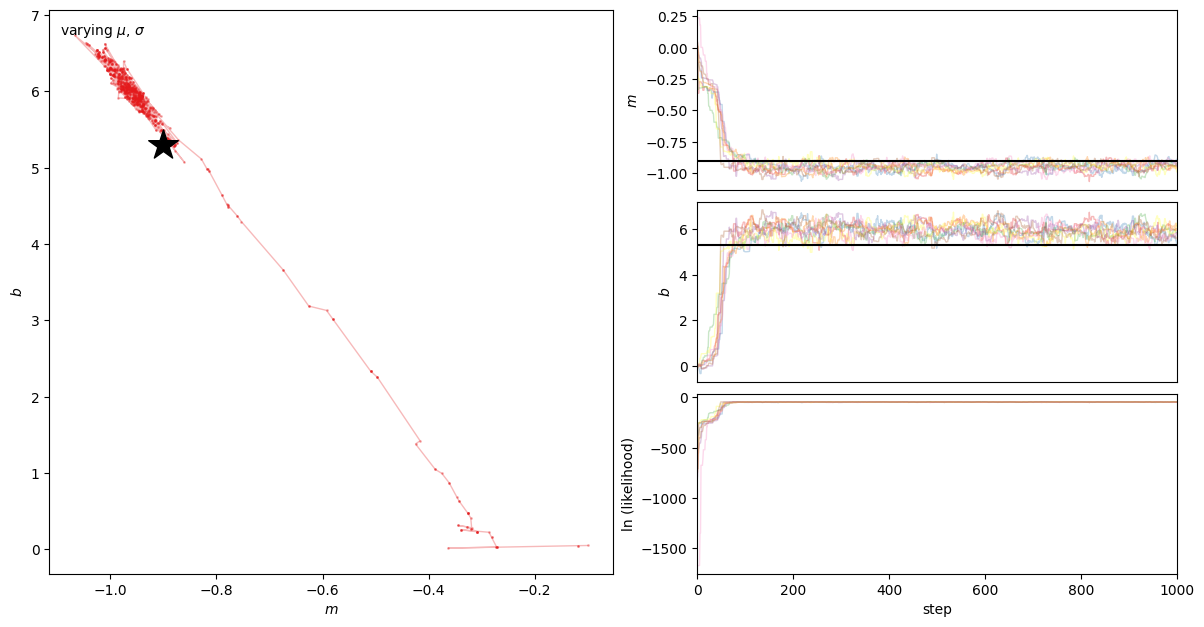

In [7]:
fig = plt.figure(figsize=(12, 6))
    
ax1 = fig.add_subplot(141)  # Note: add_subplot takes the position from left to right and top to bottom
ax1.set_position([0.05, 0.05, 0.47, 0.94])  # Set the position and size of the subplot
    
ax21 = fig.add_subplot(142)  # Note: add_subplot takes the position from left to right and top to bottom
ax21.set_position([0.59, 0.69, 0.4, 0.3])  # Set the position and size of the subplot
    
ax22 = fig.add_subplot(143)  # Note: add_subplot takes the position from left to right and top to bottom
ax22.set_position([0.59, 0.37, 0.4, 0.3])  # Set the position and size of the subplot

ax23 = fig.add_subplot(144)  # Note: add_subplot takes the position from left to right and top to bottom
ax23.set_position([0.59, 0.05, 0.4, 0.3])  # Set the position and size of the subplot

for iwalker in range(num_samples):
    # Plot one chain in 2D parameter space
    if iwalker==0:
        ax1.plot(chains[iwalker,:,0], chains[iwalker,:,1], marker='o', lw=1,markersize=1,alpha=0.3, zorder=1, color=colors[iwalker])

    # Plot the Markov Chain
    ax21.plot(chains[iwalker,:,0], lw=1, alpha=0.3, color=colors[iwalker])
    ax22.plot(chains[iwalker,:,1], lw=1, alpha=0.3, color=colors[iwalker])
    ax23.plot(lnprobability[iwalker], lw=1, alpha=0.3, color=colors[iwalker])

ax1.scatter(m_true, b_true, marker='*', c='k', s=500, zorder=2)
ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$b$')
    
ax1.text(0.02, 0.98, r'varying $\mu$, $\sigma$',
         ha='left', va='top', transform=ax1.transAxes)

# Show the truth
ax21.axhline(m_true, color='k')
ax22.axhline(b_true, color='k')

ax21.set_xlim(0, num_steps)
ax22.set_xlim(0, num_steps)
ax23.set_xlim(0, num_steps)

ax21.set_xticks([])
ax22.set_xticks([])
ax23.set_xlabel('step')

ax21.set_ylabel(r'$m$')
ax22.set_ylabel(r'$b$')
ax23.set_ylabel('ln (likelihood)')

## corner plot

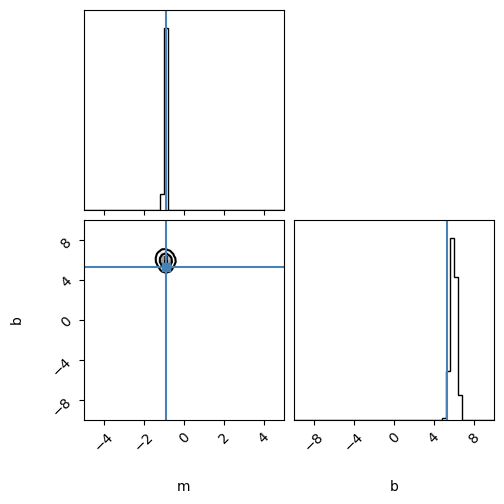

In [8]:
n_burn = 100
plot_data = chains[:,n_burn:].reshape([-1,2])
figure = corner.corner(plot_data, 
                       levels=[0, 0.68, 0.95],  # contour levels
                       color='k',alpha=1,      
                       truths=[m_true, b_true], # show the truths 
                       labels=['m','b'],
                       range=((m_min,m_max),(b_min,b_max)), bins=50, smooth=1)

## pick 100 random samples from the posterior and plot the model against data

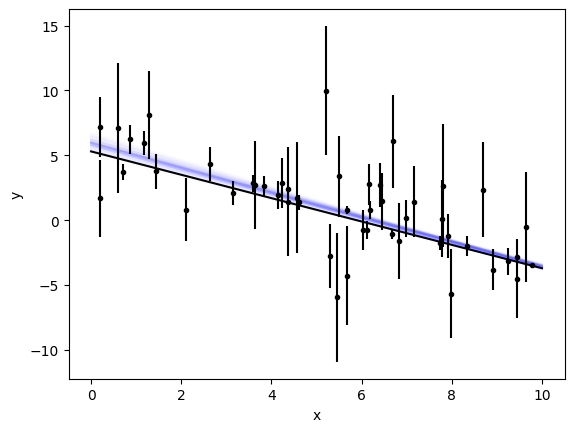

In [19]:
x_ref = np.linspace(0,10, 100)
inds = np.random.randint(plot_data.shape[0], size=100)
for ind in inds:
    m,b = plot_data[ind]
    plt.plot(x_ref, m*x_ref + b, c="blue", alpha=0.01)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_ref, m_true * x_ref + b_true, "k")
plt.xlabel('x')
plt.ylabel('y');